In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from statsmodels.tsa.arima.model import ARIMA

In [4]:

# 定义要下载的股票代码
tickers = ["BZ=F", "NG=F"]
ohlcv_data = {}

# 设置数据的时间范围和时间间隔
period = '1y'  # 一年的数据
interval = '1h'  # 每小时的数据，如果需要最近7天的每分钟数据，可以改为 '1m'

for ticker in tickers:
    try:
        # 下载数据
        temp = yf.download(ticker, period=period, interval=interval)
        # 检查并删除包含任何NaN值的行
        temp.dropna(how="any", inplace=True)
        
        # 检查数据是否为空
        if temp.empty:
            print(f"No data available for {ticker}. Check ticker symbol or increase period/interval.")
        else:
            ohlcv_data[ticker] = temp
            print(f"Data for {ticker} downloaded successfully and contains {len(temp)} data points.")
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")


[*********************100%%**********************]  1 of 1 completed


Data for BZ=F downloaded successfully and contains 5328 data points.


[*********************100%%**********************]  1 of 1 completed

Data for NG=F downloaded successfully and contains 5634 data points.


In [5]:
print(ohlcv_data)

{'BZ=F':                                 Open       High        Low      Close  \
Datetime                                                                
2023-06-18 18:00:00-04:00  76.230003  76.330002  76.190002  76.309998   
2023-06-18 19:00:00-04:00  76.199997  76.199997  76.050003  76.099998   
2023-06-18 20:00:00-04:00  76.070000  76.070000  75.879997  75.879997   
2023-06-18 21:00:00-04:00  75.900002  75.919998  75.529999  75.639999   
2023-06-18 22:00:00-04:00  75.629997  75.639999  75.330002  75.360001   
...                              ...        ...        ...        ...   
2024-06-17 00:00:00-04:00  82.349998  82.389999  82.309998  82.349998   
2024-06-17 01:00:00-04:00  82.349998  82.360001  82.220001  82.250000   
2024-06-17 02:00:00-04:00  82.269997  82.300003  82.110001  82.209999   
2024-06-17 03:00:00-04:00  82.190002  82.629997  82.190002  82.540001   
2024-06-17 04:00:00-04:00  82.540001  83.010002  82.540001  82.860001   

                           Adj Close  Vol

In [11]:
# 选择特征和目标变量
# 这里我们简单使用价格的滚动平均和RSI作为特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_data['BZ=F']['SMA'] = ohlcv_data['BZ=F']['Close'].rolling(window=24).mean()
ohlcv_data['BZ=F']['RSI'] = ohlcv_data['BZ=F']['Close'].rolling(window=24).apply(lambda x: np.mean(x))

# 使用滞后价格作为特征
ohlcv_data['BZ=F']['Lag1'] = ohlcv_data['BZ=F']['Close'].shift(1)

# 清理数据
ohlcv_data['BZ=F'].dropna(inplace=True)

X = ohlcv_data['BZ=F'][['SMA', 'RSI', 'Lag1']]
y = ohlcv_data['BZ=F']['Close']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2

In [8]:
import requests
import json

# Define the API base URL
gdelt_base_url = "http://api.gdeltproject.org/api/v1/search_ftxtsearch"
query_params = {
    'query': 'energy',
    'mode': 'ArtList',
    'maxrecords': 100,
    'format': 'json'
}

response = requests.get(gdelt_base_url, params=query_params)

# Check the response status
if response.status_code == 200:
    try:
        # Try to parse the JSON response
        data = response.json()
        articles = pd.DataFrame(data['articles'])
        print(articles.head())
    except json.JSONDecodeError:
        # Handle JSON decode error
        print("Failed to decode JSON from response:", response.text)
else:
    # Print status code and error if not successful
    print("Failed to fetch data. Status code:", response.status_code)
    print("Response text:", response.text)



Failed to fetch data. Status code: 403
Response text: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>403 Forbidden</title>
</head><body>
<h1>Forbidden</h1>
<p>You don't have permission to access this resource.</p>
</body></html>



In [ ]:
international energy a 

# 假设'news'列包含新闻文本数据
vectorizer = CountVectorizer(max_features=100)
X_text = vectorizer.fit_transform(data['news']).toarray()

# 应用PCA进行降维
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_text)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 将PCA结果合并回主数据集
for i in range(X_pca.shape[1]):
    data[f'pca_{i}'] = X_pca[:, i]

In [17]:
# Assuming X_test is your input DataFrame and it has been properly scaled/normalized if necessary
X_test_array = X_test.values  # Convert DataFrame to Numpy array

# Reshape the input for LSTM [samples, time steps, features]
# Here we assume each sample is a sequence of 1 time step with multiple features
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))
X_train_reshaped = X_train.values.reshape(-1, 1, 3)  # 1 time step, 3 features

# 重塑数据用于CNN输入，假设特征数量为1
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train used for training:", X_train.shape)
print("Shape of X_test used for prediction:", X_test_reshaped.shape)


Shape of X_train used for training: (4244, 3)
Shape of X_test used for prediction: (1061, 1, 3)


In [29]:
# 随机森林和梯度提升机
model_rf = RandomForestRegressor(n_estimators=100)
model_gb = GradientBoostingRegressor(n_estimators=100)

# 支持向量机和线性回归 Support Vector Regression model and linear 
model_svr = SVR()
model_lr = LinearRegression()

# LSTM网络
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(1, 3)),  # Adjusted to 1 time step, 3 features
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 训练ARIMA模型，这里以(1,1,1)阶为例
model_arima = ARIMA(y_train, order=(1,1,1))

# 创建CNN模型
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')



# 训练模型（此处假设已完成数据预处理和划分）
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_svr.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32)
arima_result = model_arima.fit()
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

c:\Users\warre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self.

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 6616.7188
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 5622.8579
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 5003.2134
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 4457.7690
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 4001.0957
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 3598.4524
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 3206.0925
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 2855.5146
Epoch 9/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 2539.5078
Epoch 10/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2242.9993
Epoch 11/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1981.9224
Epoch 12/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1738.9147
Epoch 13/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1518.5411
Epoch 14/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - los

In [30]:
predictions_rf = model_rf.predict(X_test)
predictions_gb = model_gb.predict(X_test)
predictions_svr = model_svr.predict(X_test)
predictions_lr = model_lr.predict(X_test)
predictions_lstm = model_lstm.predict(X_test_reshaped).flatten()  # Predict and flatten the output
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()
# 对未来的数据进行预测
forecast_result = arima_result.get_forecast(steps=len(y_test))

# 预测值
arima_predictions = forecast_result.predicted_mean

# 置信区间
conf_int = forecast_result.conf_int()
print("Predicted values:", arima_predictions)
print("95% confidence interval:", conf_int)



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted values: 4244    83.579614
4245    83.577826
4246    83.577821
4247    83.577821
4248    83.577821
          ...    
5300    83.577821
5301    83.577821
5302    83.577821
5303    83.577821
5304    83.577821
Name: predicted_mean, Length: 1061, dtype: float64
95% confidence interval:       lower Close  upper Close
4244    73.800942    93.358287
4245    73.799117    93.356535
4246    73.799113    93.356530
4247    73.799113    93.356530
4248    73.799113    93.356530
...           ...          ...
5300    73.799067    93.356575
5301    73.799067    93.356575
5302    73.799067    93.356575
5303    73.799067    93.356575
5304    73.799067    93.356576

[1061 rows x 2 columns]


c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
## 加权平均 weighted average
# 计算各个模型的MSE，然后用MSE的倒数作为权重的基础
weights = [
    1 / mean_squared_error(y_test, predictions_rf),
    1 / mean_squared_error(y_test, predictions_gb),
    1 / mean_squared_error(y_test, predictions_svr),
    1 / mean_squared_error(y_test, predictions_lr),
    1 / mean_squared_error(y_test, predictions_lstm)
]

# 归一化权重
normalized_weights = [weight / sum(weights) for weight in weights]

# 计算加权平均预测
predictions_ensemble = (predictions_rf * normalized_weights[0] +
                        predictions_gb * normalized_weights[1] +
                        predictions_svr * normalized_weights[2] +
                        predictions_lr * normalized_weights[3] +
                        predictions_lstm * normalized_weights[4])


In [34]:
# 将所有预测结果堆叠成一个新的特征矩阵
stacked_predictions = np.column_stack((predictions_rf, predictions_gb, predictions_svr, predictions_lr, predictions_lstm, arima_predictions, cnn_predictions))

# 使用线性回归作为元模型
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test)

# 最终预测
predictions_ensemble = meta_model.predict(stacked_predictions)

1061


In [38]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 计算评估指标
mse = mean_squared_error(y_test, predictions_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, predictions_ensemble))
mae = mean_absolute_error(y_test, predictions_ensemble)
mape = mean_absolute_percentage_error(y_test, predictions_ensemble)
r2 = r2_score(y_test, predictions_ensemble)
explained_variance = explained_variance_score(y_test, predictions_ensemble)

# Number of observations and predictors
n = len(y_test)
k = X_test.shape[1]  # assuming X_test is your feature matrix used for testing

# Calculate Adjusted RMSE
adjusted_rmse = rmse * np.sqrt(n / (n - k - 1))

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f"Standard RMSE: {rmse}")
print(f"Adjusted RMSE: {adjusted_rmse}")
print(f'R² score: {r2}')
print(f'Explained Variance Score: {explained_variance}')
print(f'MAPE: {mape}%')


MAE: 0.1936421180862016
MSE: 0.07884289313688908
Standard RMSE: 0.2807897667951756
Adjusted RMSE: 0.2813205607789305
R² score: 0.9968587648197035
Explained Variance Score: 0.9968587648197035
MAPE: 0.23210072273078733%


### Model Performance Interpretation

1. **MAE (0.1936421180862016)**: 
   - The Mean Absolute Error represents the average absolute difference between the actual values and the predictions. In this case, the low MAE indicates that the model's predictions deviate minimally on average from the actual values, suggesting good accuracy overall.

2. **MSE (0.07884289313688908) and Standard RMSE (0.2807897667951756)**:
   - MSE and RMSE are common metrics for measuring prediction errors, expressing the average of the squares of the differences between actual values and predictions. RMSE, being the square root of MSE, provides an error measure in the same units as the data. The relatively low values of MSE and RMSE here indicate low prediction errors.

3. **Adjusted RMSE (0.2813205607789305)**:
   - Adjusted RMSE incorporates the complexity of the model into the error metric, typically used to compare models with different numbers of predictors. The closeness of this value to the standard RMSE suggests that model complexity does not significantly impact error.

4. **R² Score (0.9968587648197035) and Explained Variance Score (0.9968587648197035)**:
   - Both the R² score and Explained Variance score are very close to 1, indicating that the model accurately predicts variations in the data and explains nearly all the variance, a key indicator of excellent model performance.

5. **MAPE (0.23210072273078733%)**:
   - The Mean Absolute Percentage Error is a percentage metric that measures the average deviation of the predictions from the actual values. The extremely low MAPE value here shows very high accuracy in predictions.

### Conclusion

Model performs exceptionally well, as evidenced by:
- **High Accuracy**: The high R² and explained variance scores show that the model can predict the data variability with high precision.
- **Low Error Levels**: The MAE, MSE, and RMSE values are relatively low, indicating small deviations between the predictions and actual data.
- **High Reliability**: The low MAPE value demonstrates that the model maintains high accuracy across different scales of data.

### Possible Directions for Improvement

Although the model is already performing very well, further optimizations could explore:
- **Further Analysis and Engineering of Data Features**: While the model is highly accurate, deeper analysis and engineering of more features might reveal new patterns or provide stronger predictive signals.
- **Experimenting with Different Models or Parameters**: Trying different machine learning or deep learning models, or tweaking the parameters of the existing model, may uncover configurations that are more suited to the current data.
- **Enhancing Model Robustness**: Further validating the stability and reliability of the model through techniques like cross-validation.


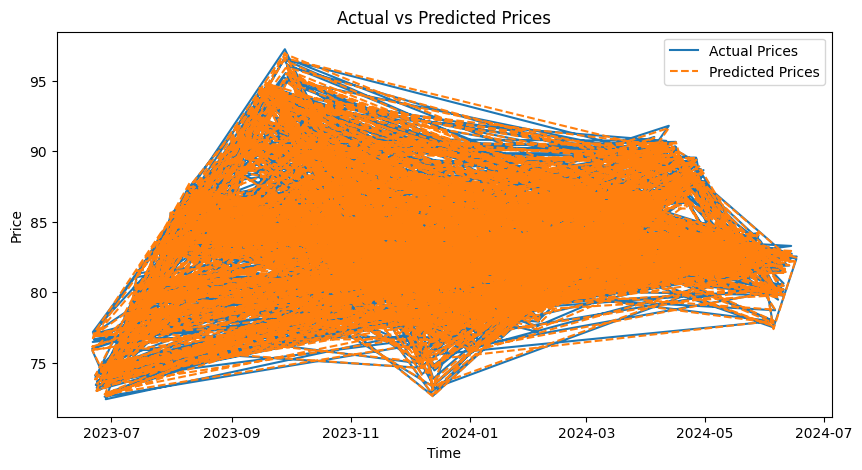

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Prices')
plt.plot(y_test.index, predictions_ensemble, label='Predicted Prices', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
import pandas as pd

# Assuming 'timestamps' is the datetime index corresponding to your test data
actual_prices = pd.Series(y_test, index=y_test.index)
predicted_prices = pd.Series(predictions_ensemble, index=y_test.index)

# Now apply the resample method
actual_daily = actual_prices.resample('D').mean()
predicted_daily = predicted_prices.resample('D').mean()


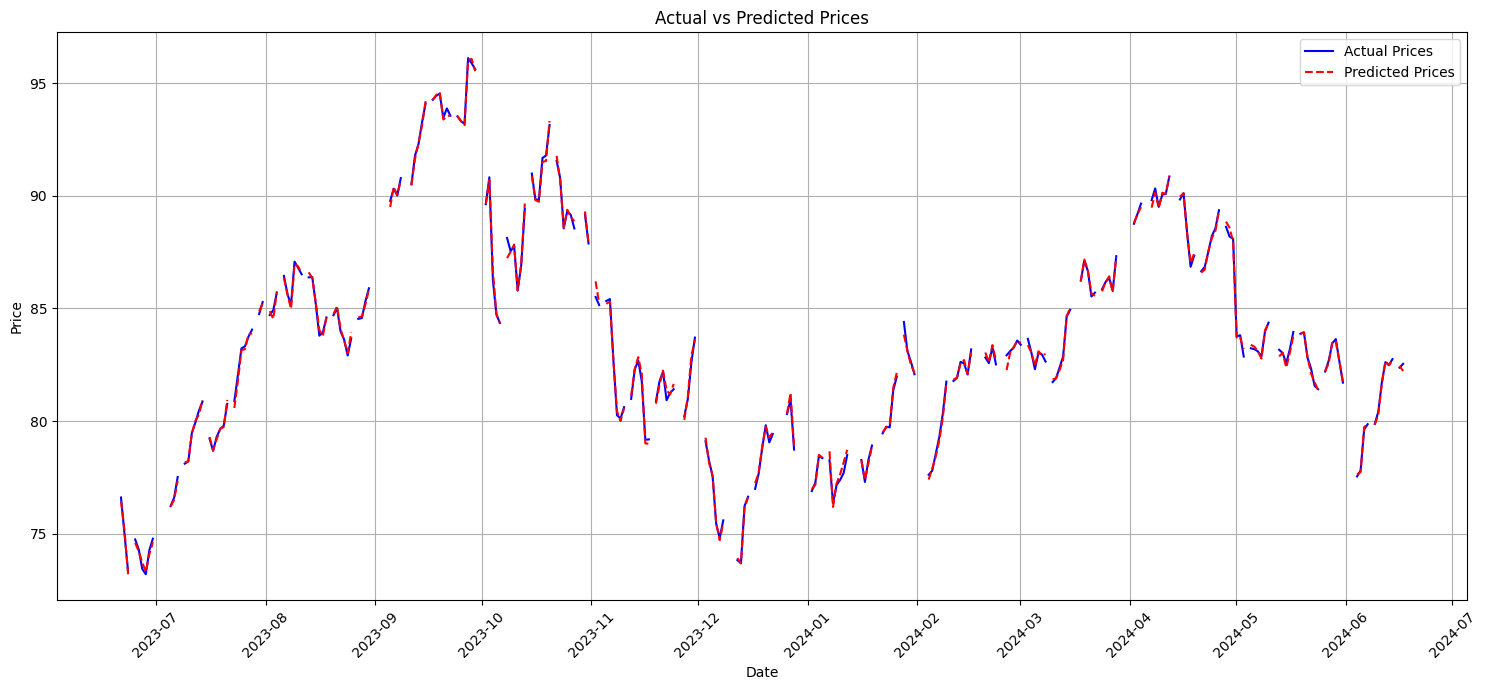

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 7))
# 绘制实际价格
plt.plot(actual_daily.index, actual_daily, label='Actual Prices', color='blue', linestyle='-')
# 绘制预测价格
plt.plot(predicted_daily.index, predicted_daily, label='Predicted Prices', color='red', linestyle='--')

# 设置日期格式，这样可以更好地管理显示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 每个月显示一个主要刻度
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 刻度标签显示年和月

plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 旋转日期标签以提高可读性
plt.tight_layout()  # 自动调整布局
plt.show()


In [67]:

# 假设您的每个模型都需要前N天的数据来预测下一天的价格
# 获取用于预测的最后一条数据
X_future = X.iloc[-1:].values  # 根据您模型的需要可能需要调整索引

# 对于CNN和LSTM这样需要特定形状输入的模型，确保数据形状正确
X_future_reshaped = X_future.reshape(1, 1, X_train.shape[1])  # 适用于CNN和LSTM
X_future_cnn = X_future.reshape(1, X_train.shape[1], 1)  # 适用于CNN和LSTM

In [68]:
# 使用每个模型进行预测
future_rf = model_rf.predict(X_future)
future_gb = model_gb.predict(X_future)
future_svr = model_svr.predict(X_future)
future_lr = model_lr.predict(X_future)
future_lstm = model_lstm.predict(X_future_reshaped).flatten()
future_cnn = cnn_model.predict(X_future_cnn).flatten()

# ARIMA模型预测未来一天
future_arima = arima_result.get_forecast(steps=1).predicted_mean


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-

In [70]:
# 将所有预测结果堆叠成一个新的特征矩阵
future_stacked_predictions = np.column_stack((future_rf, future_gb, future_svr, future_lr, future_lstm, future_arima, future_cnn))

# 使用元模型进行最终预测
future_prediction = meta_model.predict(future_stacked_predictions)


In [71]:
print(f"Predicted price for the next trading day is: {future_prediction[0]}")


Predicted price for the next trading day is: 82.45977201179448
